# Visual RAG on Refined ChartQA Dataset

In [1]:
from settings import *

## Retrieval with ColPali

Images already stored at /projects/multimodal_bootcamp/multimodal-td-2/shared/chartqa_images/val
Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/fs01/home/ws_sabbasi/projects/chartqa_visual_rag/.myvenv/lib/python3.10/site-packages/awq/__init__.py:21: DeprecationWarning: 
I have left this message as the final dev message to help you transition.

Important Notice:
- AutoAWQ is officially deprecated and will no longer be maintained.
- The last tested configuration used Torch 2.6.0 and Transformers 4.51.3.
- If future versions of Transformers break AutoAWQ compatibility, please report the issue to the Transformers project.

Alternative:
- AutoAWQ has been adopted by the vLLM Project: https://github.com/vllm-project/llm-compressor

For further inquiries, feel free to reach out:
- X: https://x.com/casper_hansen_
- LinkedIn: https://www.linkedin.com/in/casper-hansen-804005170/

  warnings.warn(_FINAL_DEV_MESSAGE, category=DeprecationWarning, stacklevel=1)
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was save

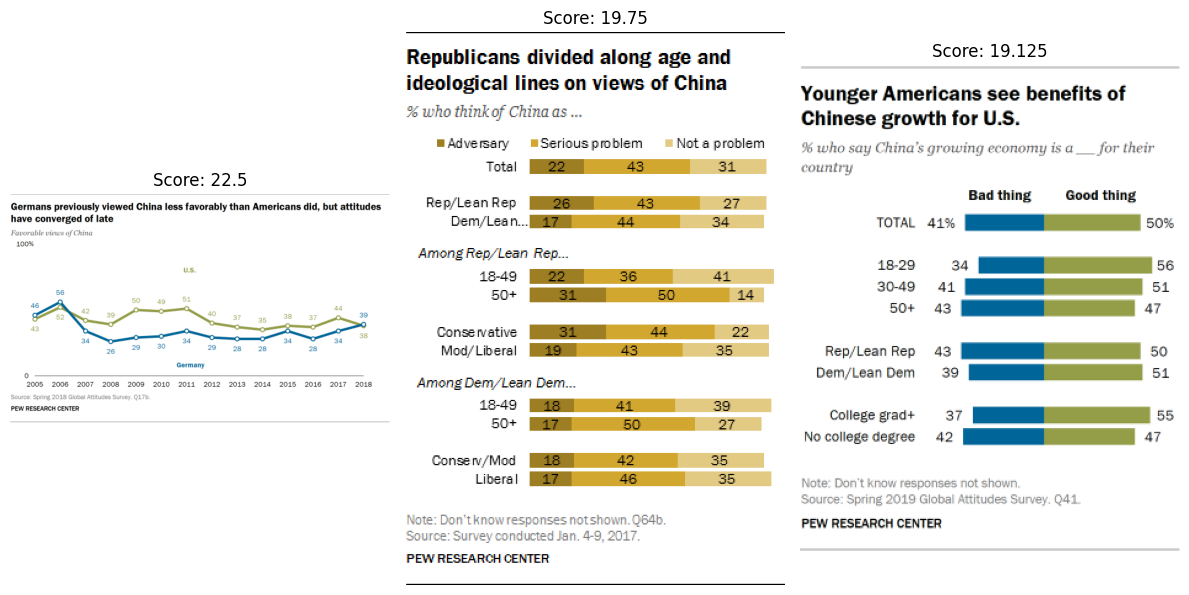

In [2]:
from multi_modal import MultiModalRetriever

ret_model_name = "colpali13"
retriever = MultiModalRetriever(model_name=ret_model_name)

# query = "What was the percentage of favorable views of China among Americans in 2015?"
query = "In which country did the highest favorable view of China reach 56%?"

ret_results = retriever.search(query, verbose=True)

## Generation with Qwen2.5 VLM

In [3]:
from multi_modal import MultiModalGenerator 

gen_model_name = "qwen25_vl_7b_instruct"
generator = MultiModalGenerator(model_name=gen_model_name)

images = [retriever.load_image(res['metadata']['image_name']) for res in ret_results]
gen_result = generator.generate(query, images=images, verbose=True)

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


The graph shows that in Germany, the highest favorable view of China reached 56% in 2006. This is indicated by the green line representing Germany's data points, which peaks at 56% in 2006 before declining slightly in subsequent years.


## Sample End-to-end Visual RAG

In [4]:
from datasets import Dataset

refined_path = f"{TEAM_ROOT_DIR}/refined_chartqa/val-100_qwen25_vl_7b_instruct"
refined_dset = Dataset.load_from_disk(refined_path)
refined_dset

Dataset({
    features: ['image', 'query', 'label', 'human_or_machine', 'image_id', 'refined_query', 'refined_label'],
    num_rows: 100
})

In [5]:
safe_dset = refined_dset.filter(lambda row: row["label"] == row["refined_label"])
safe_dset

Dataset({
    features: ['image', 'query', 'label', 'human_or_machine', 'image_id', 'refined_query', 'refined_label'],
    num_rows: 72
})

In [6]:
import multi_modal
import importlib; importlib.reload(multi_modal)
from multi_modal import MultiModalRAG

rag = MultiModalRAG(retriever=retriever, generator=generator)

Query: What year does the chart's heading reference?


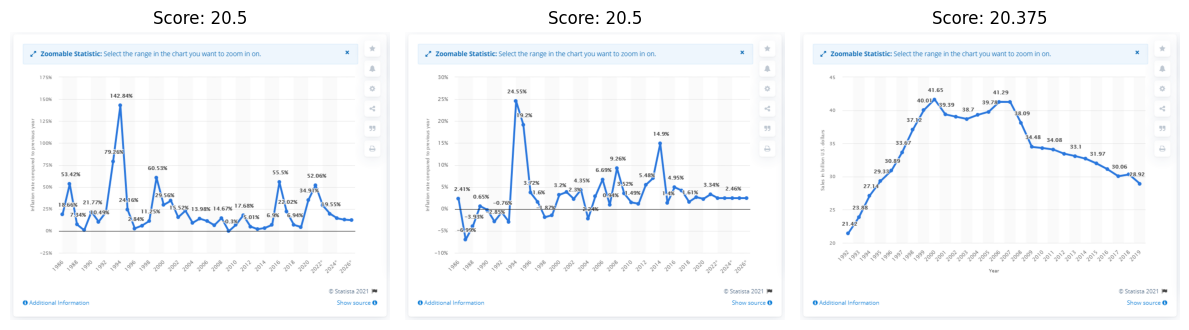

The chart's heading references the year 2021, as indicated by the copyright notice at the bottom of the image: "© Statista 2021".
GT Answer: 1911
{'ret_recall': 0, 'gen_correctness': 0}

Query: What is the average percentage share of plastic exports by Canada, Belgium, and France among the top ten exporters?


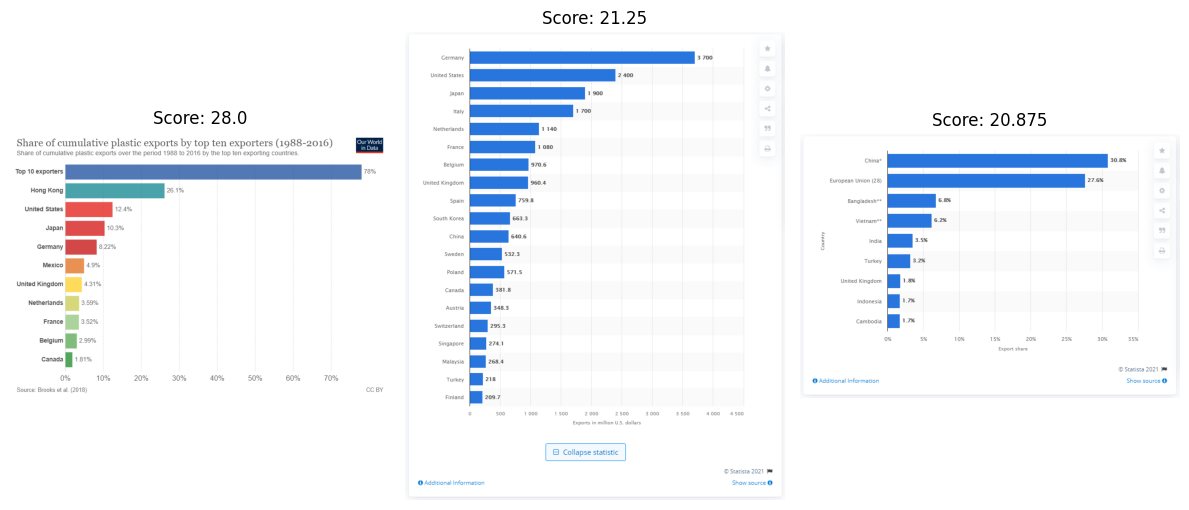

To find the average percentage share of plastic exports by Canada, Belgium, and France among the top ten exporters, we need to add their individual percentages and then divide by 3.

From the first chart:
- Canada: 1.81%
- Belgium: 2.99%
- France: 3.52%

Now, let's calculate the sum:

1.81% + 2.99% + 3.52% = 8.32%

Next, we divide this sum by 3 to get the average:

8.32% / 3 ≈ 2.77%

So, the average percentage share of plastic exports by Canada, Belgium, and France among the top ten exporters is approximately 2.77%.
GT Answer: 0.0277
{'ret_recall': 1, 'gen_correctness': 0}

Query: Which category represents the smallest portion of the pie chart?


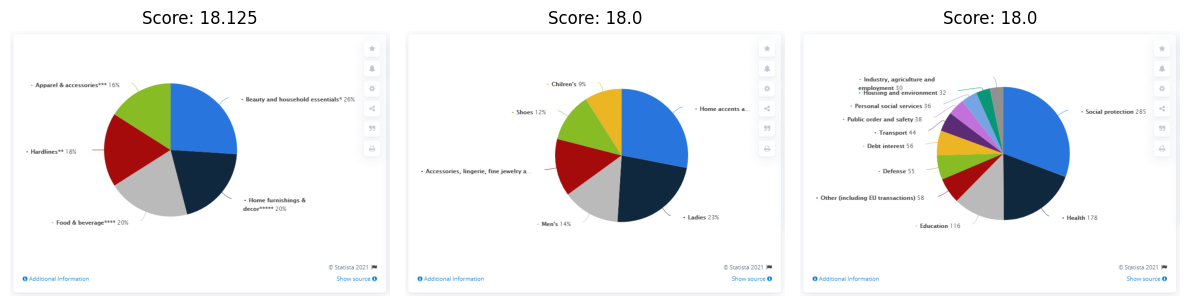

The smallest portion of the pie chart in the third image (representing spending categories) is "Industry, agriculture and employment," which accounts for 30 units.
GT Answer: Both
{'ret_recall': 0, 'gen_correctness': 0}

Query: In the graph showing death rates from substance use disorders in 1995 for two countries, how many distinct data points are represented?


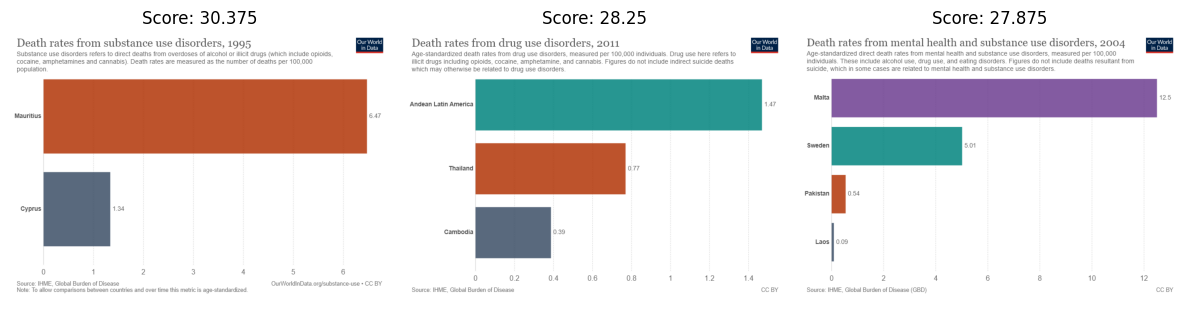

The graph shows death rates from substance use disorders in 1995 for two countries: Mauritius and Cyprus. Each country has one data point representing its death rate per 100,000 population. Therefore, there are **2 distinct data points** represented in the graph.
GT Answer: 2
{'ret_recall': 1, 'gen_correctness': 1}

Query: In which region did women have the highest average number of children over their lifetime in 1988?


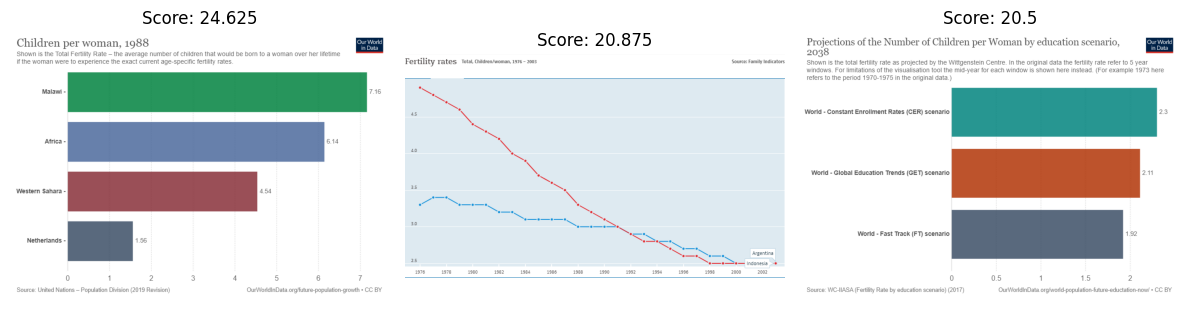

According to the first chart, women in Malawi had the highest average number of children over their lifetime in 1988, with a total fertility rate of 7.16 children per woman.
GT Answer: Malawi
{'ret_recall': 1, 'gen_correctness': 1}

Query: What age group has the highest prevalence of drug use disorders according to the data?


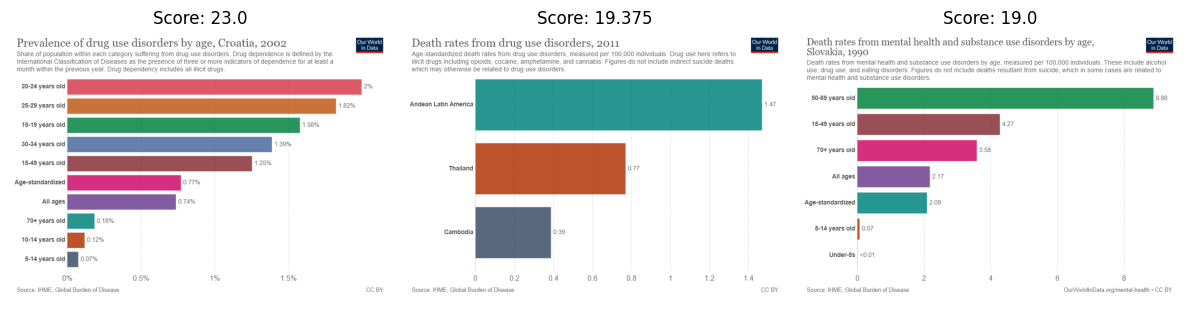

According to the data in the first chart, the age group with the highest prevalence of drug use disorders in Croatia in 2002 is 20-24 years old, with a prevalence rate of 2%.
GT Answer: 20-24 years old
{'ret_recall': 1, 'gen_correctness': 1}

Query: What is the female-to-male ratio of time devoted to unpaid care work in Italy?


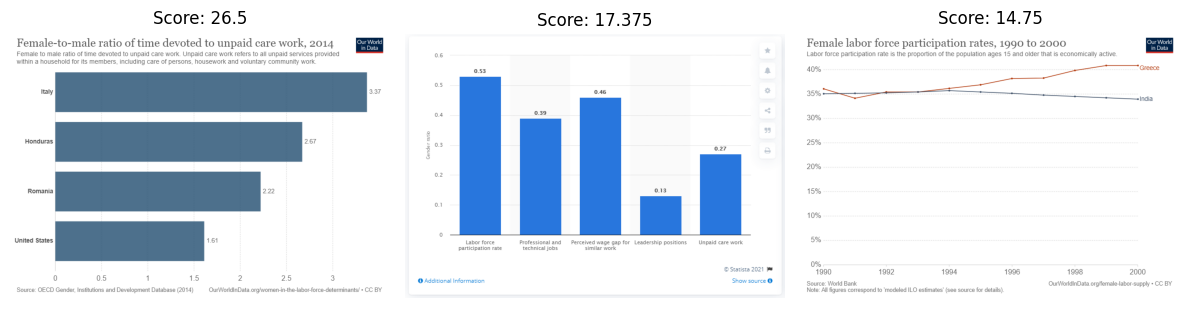

The female-to-male ratio of time devoted to unpaid care work in Italy in 2014 was 3.37.
GT Answer: 3.37
{'ret_recall': 1, 'gen_correctness': 1}

Query: What is the ratio of methane emissions from land use change and forestry to agriculture emissions in Belize in 2011?


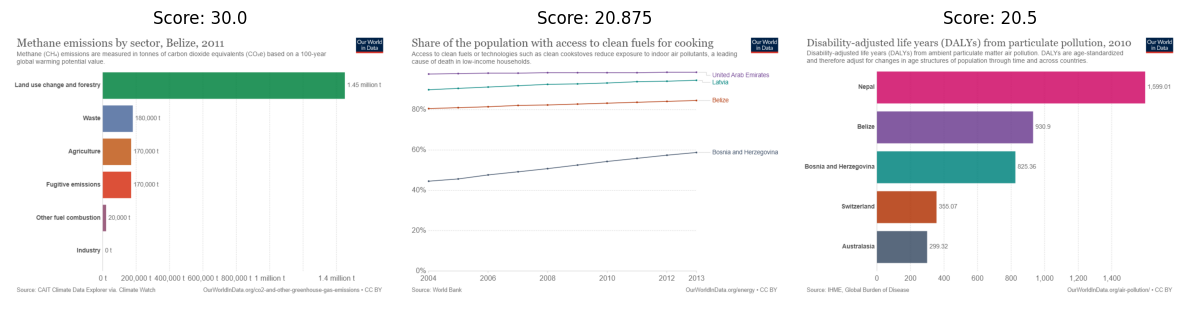

The ratio of methane emissions from land use change and forestry to agriculture emissions in Belize in 2011 can be calculated by dividing the emissions from land use change and forestry by the emissions from agriculture.

From the bar chart, we have:
- Emissions from land use change and forestry: 1.45 million tonnes (t)
- Emissions from agriculture: 170,000 t

The ratio is:

\[ \text{Ratio} = \frac{\text{Emissions from land use change and forestry}}{\text{Emissions from agriculture}} \]

\[ \text{Ratio} = \frac{1.45 \text{ million t}}{170,000 \text{ t}} \]

\[ \text{Ratio} = \frac{1,450,000 \text{ t}}{170,000 \text{ t}} \]

\[ \text{Ratio} \approx 8.53 \]

So, the ratio of methane emissions from land use change and forestry to agriculture emissions in Belize in 2011 is approximately 8.53.
GT Answer: 8.53
{'ret_recall': 1, 'gen_correctness': 1}

Query: What is the sum of the recycling rates for paper and cardboard in Spain and Canada in 1980?


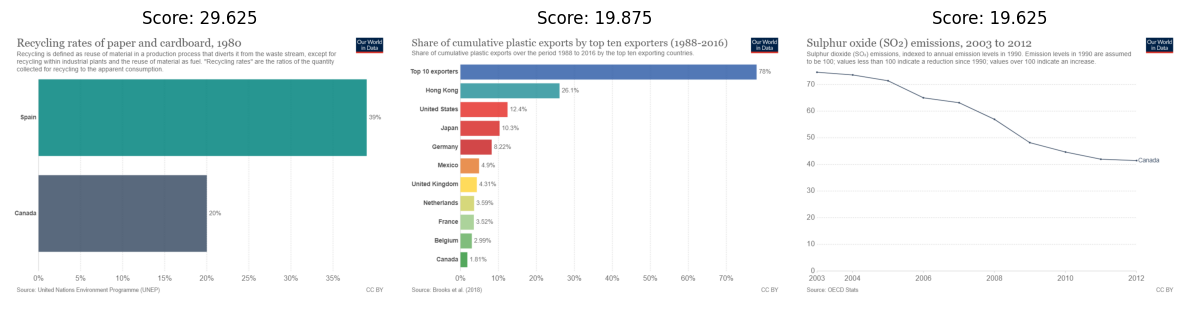

The recycling rate for paper and cardboard in Spain in 1980 was 39%, and in Canada, it was 20%. The sum of these two rates is:

39% + 20% = 59%

So, the sum of the recycling rates for paper and cardboard in Spain and Canada in 1980 is 59%.
GT Answer: 59
{'ret_recall': 1, 'gen_correctness': 1}

Query: What is the median value of the drowning death rates shown in the chart for Switzerland in 2011?


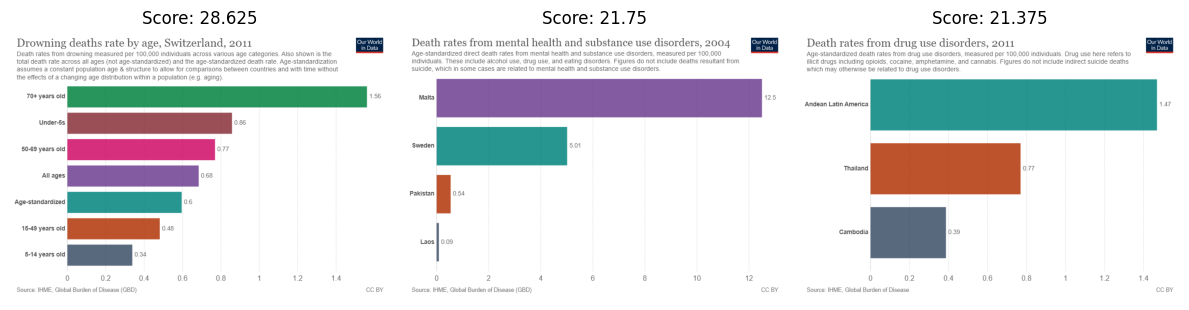

The median value of the drowning death rates shown in the chart for Switzerland in 2011 is 0.77, which corresponds to the age group "50-69 years old."
GT Answer: 0.68
{'ret_recall': 1, 'gen_correctness': 0}



In [7]:
for row in safe_dset.shuffle(seed=42).select(range(10)):
    query = row["refined_query"]
    gt_answer = row["refined_label"][0]
    gt_image_id = row["image_id"]
    
    print(f"Query: {query}")
    ret_results, gen_result = rag.run(query=query, verbose=True)
    print(f"GT Answer: {gt_answer}")
    
    metrics = rag.evaluate(query, ret_results, gen_result, gt_image_id, gt_answer)
    print(metrics)
    
    print("=" * 120 + "\n")

# rag._aggregate_metrics()

## End-to-end Visual RAG and Evaluation

In [8]:
from pathlib import Path

rag_metrics = {}
for vlm_name in ["qwen25_vl_7b_instruct", "qwen25_vl_32b_instruct", "qwen25_vl_72b_instruct_awq"]:
    refined_path = f"{TEAM_ROOT_DIR}/refined_chartqa/val-100_{vlm_name}"
    if not os.path.exists(refined_path):
        continue
        
    refined_dset = Dataset.load_from_disk(refined_path)

    safe_dset = refined_dset.filter(lambda row: row["label"] == row["refined_label"])

    # Save the RAG Results
    save_dir = Path(refined_path).parent / f"{Path(refined_path).stem}_rag_results_{ret_model_name}_{gen_model_name}"
    dset, metrics = rag.run_and_evaluate_all(safe_dset, save_dir=save_dir)
    # display(dset)
    # display(metrics)
    
    rag_metrics[vlm_name] = metrics

Visual RAG Inference and Evaluation:   0%|          | 0/72 [00:00<?, ?it/s]

Saving RAG results to /projects/multimodal_bootcamp/multimodal-td-2/shared/refined_chartqa/val-100_qwen25_vl_7b_instruct_rag_results_colpali13_qwen25_vl_7b_instruct


Saving the dataset (0/1 shards):   0%|          | 0/72 [00:00<?, ? examples/s]

Visual RAG Inference and Evaluation:   0%|          | 0/86 [00:00<?, ?it/s]

Flattening the indices:   0%|          | 0/86 [00:00<?, ? examples/s]

Saving RAG results to /projects/multimodal_bootcamp/multimodal-td-2/shared/refined_chartqa/val-100_qwen25_vl_32b_instruct_rag_results_colpali13_qwen25_vl_7b_instruct


Saving the dataset (0/1 shards):   0%|          | 0/86 [00:00<?, ? examples/s]

Visual RAG Inference and Evaluation:   0%|          | 0/95 [00:00<?, ?it/s]

Flattening the indices:   0%|          | 0/95 [00:00<?, ? examples/s]

Saving RAG results to /projects/multimodal_bootcamp/multimodal-td-2/shared/refined_chartqa/val-100_qwen25_vl_72b_instruct_awq_rag_results_colpali13_qwen25_vl_7b_instruct


Saving the dataset (0/1 shards):   0%|          | 0/95 [00:00<?, ? examples/s]

In [11]:
import pandas as pd

metrics_df = pd.DataFrame(rag_metrics).transpose().multiply(100).round(2)
metrics_df

,ret_recall,gen_correctness
qwen25_vl_7b_instruct,88.89,69.44
qwen25_vl_32b_instruct,95.35,73.26
qwen25_vl_72b_instruct_awq,98.95,66.32
